In [1]:
import os,glob
import nibabel as nib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
#import pandas as pd
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

print(tf.__version__)

2.6.2


In [2]:

# Set seed value
seed_value = 1
os.environ['PYTHONHASHSEED'] = str(seed_value)
# set python built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# set numpy pseudo-random generator at a fixed value
np.random.seed(seed_value)
# from comet_ml import Experiment
# Set tensorflow pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# Configure a new global tensorflow session
from tensorflow.python.keras import backend as K 
K.clear_session()
# session_conf = tf.compat.v1.ConfigProto()
# session_conf.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 


Num GPUs Available:  1


In [4]:
# Resizing images if needed
SIZE_X = 384
SIZE_Y = 384
n_classes = 5
batch_size_unet = 8
epochs_unet = 5


In [6]:
#Defining Paths to Dataset
# dataInputPath = '/data/scratch/aalexopoulos/'
dataInputPath = '/media/anastasis/My Harddisk2/ThesisImages/OAI_2/slices_2/'
imageInputPath = os.path.join(dataInputPath, 'img_test')
maskInputPath = os.path.join(dataInputPath, 'mask_test')

test_img_paths = sorted([
    os.path.join(imageInputPath, fname) for fname in os.listdir(imageInputPath) 
    if fname.endswith('.png') and not fname.startswith('.') 
])

test_mask_paths = sorted([
    os.path.join(maskInputPath, fname) for fname in os.listdir(maskInputPath) 
    if fname.endswith('.png') and not fname.startswith('.') 
])
# print('Number of samples: ',  len(test_img_paths))
# for img_path, mask_path in zip(test_img_paths[:5],test_mask_paths[:5]):
#     print(img_path,'\n',mask_path)

In [6]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

class MRIData(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=8, dim=(384,384), n_channels=1,
                 n_classes=5, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.ones((self.batch_size, *self.dim, self.n_channels))
        y = np.ones((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            ImagePath = os.path.join(imageInputPath,ID)
            X_temp = cv2.imread(ImagePath, 0)
            X_temp = np.array(X_temp)
            X_temp = np.expand_dims(X_temp, axis=2)
            X[i,:,:] = X_temp

             # Store class
            MaskPath = os.path.join(maskInputPath,ID)
            y_temp = cv2.imread(MaskPath, 0)
            y_temp = np.array(y_temp)
            y_temp = np.expand_dims(y_temp, axis=2)
            n,h,w = y_temp.shape
            y_temp = y_temp.reshape(-1,)
            y_temp = labelencoder.fit_transform(y_temp)
            y_temp = y_temp.reshape(n,h,w)
            y[i,:,:] = y_temp

        # return X.astype(np.float16), tf.keras.utils.to_categorical(y, num_classes=self.n_classes).astype(np.float16)
        return X, tf.keras.utils.to_categorical(y,num_classes=self.n_classes).astype('float16')


In [7]:
file_IDs = sorted(os.listdir(imageInputPath))
label_IDs = sorted(os.listdir(maskInputPath))

In [8]:
#Parameters
params = {'dim':(384,384),
          'batch_size':8,
          'n_classes':5,
          'n_channels':1,
          'shuffle':True}

testing_gen = MRIData(file_IDs,**params)
print('testing_gen created',testing_gen[0][1].shape,testing_gen[0][1].dtype)


testing_gen created (8, 384, 384, 5) float16


In [7]:
# Defining the DICE COEFFICIENT
def dice_coe(output, target, loss_type='jaccard',axis=(1,2,3),smooth=1e-5):
    inse = tf.reduce_sum(output*target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output*output,axis=axis)
        r = tf.reduce_sum(target*target,axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output,axis=axis)
        r = tf.reduce_sum(target,axis=axis)
    else:
        raise Exception('Unknown loss_type')
    
    dice = (2.*inse+smooth)/(l+r+smooth)

    dice = tf.reduce_mean(dice,name='dice_coe')
    return dice


In [8]:
from tensorflow.keras.models import load_model
tf.keras.backend.clear_session()
dependencies = {
    'dice_coe': dice_coe
}
# loaded_model_B8E5 = load_model('/data/scratch/aalexopoulos/outputs/UNetX2'+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet), custom_objects=dependencies)
filename = '/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5_cluster/UNetX2'+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)
loaded_model_B8E5 = load_model(filename,custom_objects = dependencies)

In [9]:
loaded_model_B8E5.metrics_names


['loss', 'dice_coe', 'accuracy']

In [12]:
y_eval = loaded_model_B8E5.evaluate(testing_gen,
            batch_size = batch_size_unet,
            verbose=1)


2022-02-16 16:48:50.490285: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 23592960 exceeds 10% of free system memory.
2022-02-16 16:48:50.534814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-16 16:48:50.553033: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz
2022-02-16 16:48:51.089403: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 23592960 exceeds 10% of free system memory.
2022-02-16 16:48:51.094892: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 75497472 exceeds 10% of free system memory.
2022-02-16 16:48:51.177600: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 75497472 exceeds 10% of free system memory.
2022-02-16 16:48:51.244933: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.


2020/2020 [==============================] - 3006s 1s/step - loss: 0.0161 - dice_coe: 0.9954 - accuracy: 0.9937


In [13]:
y_eval = np.array(y_eval)
y_eval

array([0.01606861, 0.99539304, 0.99371314])

In [14]:
# np.savetxt('/data/scratch/aalexopoulos/outputs/UNetX2_eval'+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+'.csv',y_eval,delimiter = ',')
np.savetxt('/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5_cluster/UNetX2_eval'+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+'.csv',y_eval,delimiter = ',')


In [10]:
# Capture training image info as a list
test_images = []

for filename in test_img_paths[-160:]:
    img = cv2.imread(filename,cv2.IMREAD_UNCHANGED)
    test_images.append(img)


test_images = np.array(test_images)
print('Test Images loaded: ',test_images.shape)


Test Images loaded:  (160, 384, 384)


In [11]:
test_masks = []

for filename in test_mask_paths[-160:]:
    img = cv2.imread(filename,0)
    test_masks.append(img)

test_masks = np.array(test_masks)
print('Test Masks Loaded: ',test_masks.shape)

Test Masks Loaded:  (160, 384, 384)


In [12]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h , w = test_masks.shape
test_masks_reshaped = test_masks.reshape(-1,)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape  = test_masks_reshaped_encoded.reshape(n, h, w)
print('Test_masks_encoded_original_shape loaded: ', test_masks_encoded_original_shape.shape)

Test_masks_encoded_original_shape loaded:  (160, 384, 384)


In [13]:
test_images_input = np.expand_dims(test_images,axis=3)
test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3)
print(test_masks_input.shape, test_images_input.shape)

# test_masks_cat = to_categorical(test_masks_input,num_classes=n_classes)

# print(test_masks_cat.shape, np.unique(test_masks_cat[0][100]), np.unique(test_masks_cat))

(160, 384, 384, 1) (160, 384, 384, 1)


In [14]:
y_pred = loaded_model_B8E5.predict(test_images_input,batch_size = batch_size_unet,verbose=1)

20/20 [==============================] - 9s 150ms/step


In [20]:
y_pred.shape
# np.argmax(y_pred, axis=3).shape

(160, 384, 384, 5)

In [15]:

# y_pred=loaded_model.predict(testing_gen)
y_pred_argmax=np.argmax(y_pred, axis=3)

#Using built in keras function to get the Mean Intersection over Union
from tensorflow.keras.metrics import MeanIoU

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_masks_input[:,:,:,0], y_pred_argmax)
mean_IoU = IOU_keras.result().numpy()


#To calculate IoU for each class..but still have to change this to Dice-score
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4]+ values[1,0]+ values[2,0]+ values[3,0]+ values[4,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4]+ values[0,1]+ values[2,1]+ values[3,1]+ values[4,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4]+ values[0,2]+ values[1,2]+ values[3,2]+ values[4,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[4,2]+ values[0,3]+ values[1,3]+ values[2,3]+ values[4,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3]+ values[0,4]+ values[1,4]+ values[2,4]+ values[3,4])

print("IoU for background is: ", class1_IoU)
print("IoU for femoral bone is: ", class2_IoU)
print("IoU for femoral cartilage is: ", class3_IoU)
print("IoU for tibial bone is: ", class4_IoU)
print("IoU for tibial cartilage is: ", class5_IoU)

results_IoU = np.array([mean_IoU,class1_IoU,class2_IoU,class3_IoU,class4_IoU,class5_IoU])
# np.savetxt("/data/scratch/aalexopoulos/outputs/UNetX2_results_IoU"+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+".csv", results_IoU, delimiter=",")
np.savetxt("/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5_cluster/UNetX2_results_IoU"+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+".csv", results_IoU, delimiter=",")


IoU for background is:  0.99196494
IoU for femoral bone is:  0.9696482
IoU for femoral cartilage is:  0.797973
IoU for tibial bone is:  0.96512794
IoU for tibial cartilage is:  0.7411861


(1, 384, 384, 1) (384, 384, 1)


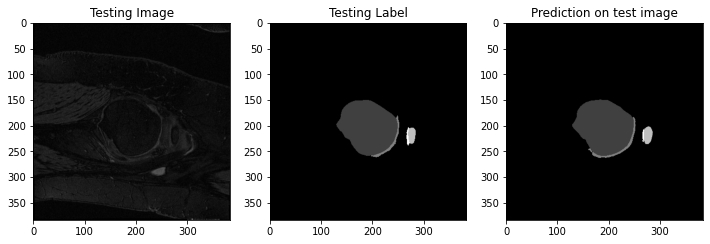

In [22]:
#Predict on a few images
import random

test_img_number = random.randint(0, len(test_images_input))
test_img =test_img_paths[test_img_number]
ImagePath = test_img
test_img = load_img(ImagePath, color_mode="grayscale")
test_img = np.expand_dims(test_img, 2)
test_img_input= np.expand_dims(test_img, axis=0)
ground_truth=test_mask_paths[test_img_number]
MaskPath = ground_truth
ground_truth = load_img(MaskPath, color_mode="grayscale")
ground_truth = np.expand_dims(ground_truth, 2)
print(test_img_input.shape, ground_truth.shape)
prediction = loaded_model_B8E5.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)



fig = plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img[0,:,:], cmap='gray')
savepath = '/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5_cluster/predictions/UNetX2_pred_{}_B{}_E{}.png'.format(str(test_img_number),str(batch_size_unet),str(epochs_unet))
plt.savefig(savepath,bbox_inches='tight',dpi=100,facecolor='white')
plt.show()

In [23]:
loaded_model_B8E5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 384, 384, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 384, 384, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________